In [2]:
import warnings
warnings.filterwarnings('ignore')

### Import the sql dataset

In [3]:
import sqlite3
import pandas as pd

connection = sqlite3.connect('database.sqlite')

# polarisable_dataset = dataset that contains Score = {1,2,4,5} assuming Score = 3 implies neutral comments and
# Score < 3 implies negative comment and Score > 3 implies positive comment
polarisable_dataset = pd.read_sql_query('select * from REVIEWS WHERE Score != 3', connection)
polarisable_dataset.shape

(525814, 10)

In [4]:
polarisable_dataset = polarisable_dataset[:5000:]

In [5]:
polarisable_dataset.shape

(5000, 10)

### Replace values in Score column in polarisable dataset with 'positive' and 'negative'

In [6]:
scores = polarisable_dataset['Score']

polarised_scores = scores.map(lambda x: 0 if x<3 else 1)

# polarised_scores.head()

polarisable_dataset['Score'] = polarised_scores
polarised_dataset = polarisable_dataset

In [7]:
polarised_dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Exploratory Data Analysis

##### 1. Deduplication
If a user id has multiple entries for the same timestamp, then it should be removed because it is likely that multiple entries at the same timestamp were for the same product of different variety which has a different product id than other variants

##### Observation 1- There are 197082 duplicate entries (using rule-1)

In [8]:
print(polarised_dataset.duplicated(['UserId', 'Time']).sum())



52


In [9]:
deduplicated_dataset = polarised_dataset.drop_duplicates(subset = {'UserId', 'Time'}, keep = 'first', inplace = False)
deduplicated_dataset.shape

(4948, 10)

#### 2. Text preprocessing- Removing html and punctuations

In [10]:
deduplicated_dataset.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [11]:
deduplicated_dataset['Text'].head(1)

0    I have bought several of the Vitality canned d...
Name: Text, dtype: object

In [12]:
# dataset cleaners

import re

def remove_html(sentence):
    html_tag_re_obj = re.compile('<.*>?')
    return re.sub(html_tag_re_obj, ' ', sentence)

def remove_punctuations(sentence):
    cleaned_sentence = re.sub(r'[^a-zA-Z]', r' ', sentence)
    return cleaned_sentence

In [13]:
# clean dataset

corpus = deduplicated_dataset['Text']

cleaned_corpus = []
for doc in corpus.values:
    cleaned_doc = remove_html(doc)
    cleaned_doc = remove_punctuations(cleaned_doc)
    cleaned_corpus.append(cleaned_doc)

deduplicated_dataset['Text'] = cleaned_corpus

#### 2. Text preprocessing- Removing stop words

In [14]:
from nltk.corpus import stopwords

In [15]:
print(set(stopwords.words('english')))

{'themselves', 'nor', 'this', 'more', 'me', 'will', "doesn't", 'most', 'i', 'what', "didn't", 'both', 'and', 'same', "weren't", 'with', 'any', 'some', 't', 'but', 'mustn', 'do', 'didn', 'there', 'you', 'our', "won't", 'am', 'been', 'which', 'hasn', 'won', 'where', 'myself', 'very', 'couldn', 'its', 'shouldn', 'does', "hadn't", 'are', "shouldn't", 'yourself', 'hers', 'him', 'these', 'o', 'off', "wasn't", "hasn't", 'while', 'wasn', 'once', 'theirs', 'against', 'doesn', 'during', 'your', 'her', 'ourselves', 'yourselves', 'my', "mightn't", 'she', 'only', 'or', 'own', 'should', "you'd", 'a', 'mightn', 'than', 'aren', 'by', 'for', "aren't", 's', 'between', 'ain', 'into', "shan't", 'under', 'they', 'to', 'had', 'again', 'ours', 'until', 'of', 'each', 'from', 'is', "you're", "it's", "that'll", 'on', 'having', 'no', 'm', 'here', 'can', 'an', 'if', 'how', 'the', "should've", 'be', 'why', 're', 'their', 'who', "haven't", "wouldn't", 'have', 'himself', 'he', 'y', 'his', 'ma', 'being', "couldn't", 

In [16]:
## Since the negative food reviews are likely to contain words like "don't", "didn't", etc that impart important
## meaning to the review, we check if such words exist in the corpus that we have. If these words are in the corpus,
## then they should not be in the list of stop words that we use for removing the stopwords from our corpus

count = 0
for doc in deduplicated_dataset['Text']:
    if "not" in doc:
        count += 1

print(count)

count = 0
for doc in deduplicated_dataset['Text']:
    if "don't" in doc:
        count += 1

print(count)

count = 0
for doc in deduplicated_dataset['Text']:
    if "didn't" in doc:
        count += 1

print(count)

1536
0
0


In [17]:
stopwords = stopwords.words('english')

In [18]:
## 'not' is present in 104301 docs in the corpus, so we modify the list of stopwords to not contain this word

stopwords_set = set(stopwords)

stopwords_set.remove('not')

In [19]:
print(stopwords_set)

{'themselves', 'nor', 'this', 'more', 'me', 'will', "doesn't", 'most', 'i', 'what', "didn't", 'both', 'and', 'same', "weren't", 'with', 'any', 'some', 't', 'but', 'mustn', 'do', 'didn', 'there', 'you', 'our', "won't", 'am', 'been', 'which', 'hasn', 'won', 'where', 'myself', 'very', 'couldn', 'its', 'shouldn', 'does', "hadn't", 'are', "shouldn't", 'yourself', 'hers', 'him', 'these', 'o', 'off', "wasn't", "hasn't", 'while', 'wasn', 'once', 'theirs', 'against', 'doesn', 'during', 'your', 'her', 'ourselves', 'yourselves', 'my', "mightn't", 'she', 'only', 'or', 'own', 'should', "you'd", 'a', 'mightn', 'than', 'aren', 'by', 'for', "aren't", 's', 'between', 'ain', 'into', "shan't", 'under', 'they', 'to', 'had', 'again', 'ours', 'until', 'of', 'each', 'from', 'is', "you're", "it's", "that'll", 'on', 'having', 'no', 'm', 'here', 'can', 'an', 'if', 'how', 'the', "should've", 'be', 'why', 're', 'their', 'who', "haven't", "wouldn't", 'have', 'himself', 'he', 'y', 'his', 'ma', 'being', "couldn't", 

In [20]:
## lower casing all docs in corpus (deduplicated_dataset['Text'])

lower_cased_docs = [doc.lower() for doc in deduplicated_dataset['Text']]
deduplicated_dataset['Text'] = lower_cased_docs

In [21]:
corpus = deduplicated_dataset['Text'] # corpus contains cleaned docs
print(type(corpus))

<class 'pandas.core.series.Series'>


In [22]:
docs_without_stop_words = []
for i, doc in enumerate(corpus):
    non_stop_words_in_doc = []
    for word in doc.split():
        if word not in stopwords_set:
            non_stop_words_in_doc.append(word)
            
    
    docs_without_stop_words.append(' '.join(non_stop_words_in_doc))

In [23]:
print(docs_without_stop_words[:10])

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted not sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven not chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal', 'got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon root beer melon peppermint grape etc complaint bit much red black licorice flavored pieces not 

#### 2. Text preprocessing- Stemming

In [24]:
from nltk.stem import SnowballStemmer

In [25]:
stemmer = SnowballStemmer('english')

In [26]:
stemmer.stem('found')

'found'

In [27]:
stemmed_corpus = [] # docs with stemmed words
for doc in docs_without_stop_words:
    stemmed_words = []
    for word in doc.split():
        stemmed_words.append(stemmer.stem(word))
    stemmed_doc = ' '.join(stemmed_words)
    stemmed_corpus.append(stemmed_doc)

In [28]:
print(stemmed_corpus[:10])

['bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better', 'product arriv label jumbo salt peanut peanut actual small size unsalt not sure error vendor intend repres product jumbo', 'confect around centuri light pillowi citrus gelatin nut case filbert cut tini squar liber coat powder sugar tini mouth heaven not chewi flavor high recommend yummi treat familiar stori c lewi lion witch wardrob treat seduc edmund sell brother sister witch', 'look secret ingredi robitussin believ found got addit root beer extract order good made cherri soda flavor medicin', 'great taffi great price wide assort yummi taffi deliveri quick taffi lover deal', 'got wild hair taffi order five pound bag taffi enjoy mani flavor watermelon root beer melon peppermint grape etc complaint bit much red black licoric flavor piec not particular favorit kid husband last two week would recommend brand taffi delight treat', 'saltwat 

### 3. Bag of Words

#### 3.1. Simple vector representation of docs in the corpus

In [29]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
count_vectorizer= CountVectorizer()

vector_of_words = count_vectorizer.fit_transform(np.array(stemmed_corpus))

In [31]:
type(vector_of_words)

scipy.sparse.csr.csr_matrix

In [32]:
# print(vector_of_words)

### T-SNE plot for simple-vector-model-matrix for our corpus

In [33]:
from sklearn.manifold import TSNE

In [34]:
vector_of_words_subset = vector_of_words[:2000] ## because t-sne will take quite long on my machine to train

In [35]:
vector_of_words.shape

(4948, 7436)

In [36]:
vector_of_words_subset.shape

(2000, 7436)

In [37]:
vector_of_words_subset[0, 0]

0

In [38]:
t_sne = TSNE(n_components = 2, random_state = 0, perplexity = 50)

In [39]:
dim_reduced_corpus = t_sne.fit_transform(vector_of_words_subset.todense())

In [40]:
type(dim_reduced_corpus)

numpy.ndarray

In [41]:
dim_reduced_corpus.shape

(2000, 2)

In [42]:
labels_2000 = deduplicated_dataset['Score'].head(2000)

In [43]:
labels_2000 = np.array(labels_2000)

In [44]:
labels_2000 = labels_2000.reshape(2000, 1)

In [45]:
dim_reduced_corpus_with_labels = np.concatenate((dim_reduced_corpus, labels_2000), axis = 1)

In [46]:
dim_reduced_corpus_with_labels_df = pd.DataFrame(dim_reduced_corpus_with_labels, columns = ('Dim1', 'Dim2', 'Label'))

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

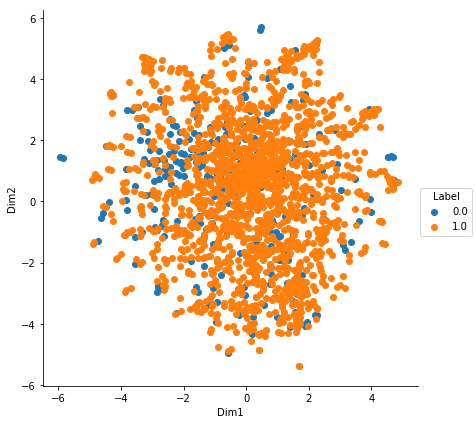

In [48]:
sns.FacetGrid(dim_reduced_corpus_with_labels_df, hue = 'Label', size = 6)\
    .map(plt.scatter, 'Dim1', 'Dim2')\
    .add_legend()

plt.show()

### T-SNE plot for Tf-idf representation

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
tfidf_vectorizer = TfidfVectorizer()

##### For CountVectorizer, we passed the entire corpus, but used only 2000 egs to train the T-SNE model. For Tf-idf vector plot also we shall use 2000 examples to train tfidf vectorizer, because these are the examples that will actually be used for current exercise (because of hardware limitations).

In [51]:
vector_of_words = tfidf_vectorizer.fit_transform(stemmed_corpus)

In [52]:
vector_of_words_subset = vector_of_words[:2000]

In [53]:
type(vector_of_words)

scipy.sparse.csr.csr_matrix

In [54]:
vector_of_words_subset.shape

(2000, 7436)

In [55]:
vector_of_words_subset_dense = vector_of_words_subset.todense()

In [56]:
type(vector_of_words_subset_dense)

numpy.matrixlib.defmatrix.matrix

In [57]:
dimension_reduced_corpus_2000 = t_sne.fit_transform(vector_of_words_subset_dense)

In [58]:
dimension_reduced_corpus_2000.shape

(2000, 2)

In [59]:
labels_2000.shape

(2000, 1)

In [60]:
dimesion_reduced_corpus_labels_2000 = np.concatenate((dimension_reduced_corpus_2000, labels_2000), axis = 1)

#### The todense() method seems to be doing something very "dense" (significant), somethign difficult to comprehend, but all it does is, converts the sparse matrix representation to a numpy matrix representation.

In [61]:
dimension_reduced_corpus_labels_2000_df = pd.DataFrame(dimesion_reduced_corpus_labels_2000, columns = ('Dim1', 'Dim2', 'Label'))

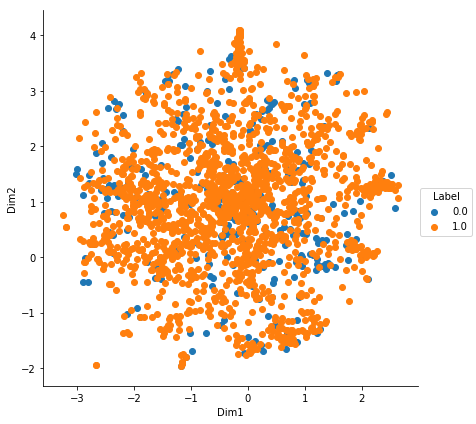

In [62]:
sns.FacetGrid(dimension_reduced_corpus_labels_2000_df, hue = 'Label', size = 6)\
    .map(plt.scatter, 'Dim1', 'Dim2')\
    .add_legend()

plt.show()

### T-SNE for average word2vec

In [63]:
import gensim

#### unlike CountVectorizer, or tfidf vectorizer, the word2vec model requires each sentence in the corpus to be a list of words, rather than one complete string of sentence

In [162]:
deduplicated_dataset.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [168]:
deduplicated_dataset.iloc[29, 6]

1

In [169]:
list_of_tokenized_sentences = [] # each sentence is converted into a list of words, and list_of_tokenized_sentences
                                # stores the list of all these list of words
count = 0
labels_2000 = []
for index, sentence in enumerate(stemmed_corpus[:2008]): # 8 sentences in stemmed_corpus are empty
    if(len(sentence) == 0):
        continue
    
    # using iloc because loc helps retrieving rows and columns by labels (row label and column label, not indices) \
    # the labels in the rows are not continuous, for eg, row label 29 is missing. this was causing error. \
    # iloc on the other hand, uses integer position (indices) to access rows and columns, as in case of normal \
    # arrays.
    labels_2000.append(deduplicated_dataset.iloc[index, 6]) # 'Score' index position = 6
    list_of_tokenized_sentences.append(sentence.split())

In [142]:
print(list_of_tokenized_sentences[:5])
len(list_of_tokenized_sentences)

[['bought', 'sever', 'vital', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicki', 'appreci', 'product', 'better'], ['product', 'arriv', 'label', 'jumbo', 'salt', 'peanut', 'peanut', 'actual', 'small', 'size', 'unsalt', 'not', 'sure', 'error', 'vendor', 'intend', 'repres', 'product', 'jumbo'], ['confect', 'around', 'centuri', 'light', 'pillowi', 'citrus', 'gelatin', 'nut', 'case', 'filbert', 'cut', 'tini', 'squar', 'liber', 'coat', 'powder', 'sugar', 'tini', 'mouth', 'heaven', 'not', 'chewi', 'flavor', 'high', 'recommend', 'yummi', 'treat', 'familiar', 'stori', 'c', 'lewi', 'lion', 'witch', 'wardrob', 'treat', 'seduc', 'edmund', 'sell', 'brother', 'sister', 'witch'], ['look', 'secret', 'ingredi', 'robitussin', 'believ', 'found', 'got', 'addit', 'root', 'beer', 'extract', 'order', 'good', 'made', 'cherri', 'soda', 'flavor', 'medicin'], ['great', 'taffi', 'great', 'price', 'wide', 'ass

2000

In [143]:
# print(list_of_tokenized_sentences[:3])

In [144]:
# since a small subset of corpus is being used, we take min_count = 1, otherwise some words get skipped\
# (eg- 'vital' got skipped when min_count was set at its default value of 5)
w2v_model = gensim.models.Word2Vec(list_of_tokenized_sentences, min_count = 1, size = 50, workers = 4)

In [145]:
w2v_model.wv['vital'] #-- Word2Vec skipped this when min_count = 5

array([-0.00571695, -0.00522971,  0.00327094,  0.01573481, -0.00259414,
       -0.00840276,  0.00438602,  0.01063695,  0.00488629,  0.00737671,
       -0.00698465,  0.01019315,  0.00375559, -0.00458602, -0.00071058,
        0.00531004, -0.00628097,  0.0043491 , -0.00366945, -0.00472308,
        0.01026191, -0.00038182,  0.00962209,  0.00543495, -0.00301596,
        0.00307356,  0.00570627,  0.00473656,  0.00410744, -0.00010785,
        0.00322717, -0.00231548, -0.0093532 , -0.00367299,  0.01041079,
       -0.00701553, -0.00052866, -0.00281973,  0.00965878, -0.00224906,
       -0.00386356, -0.00804774,  0.00114302, -0.01143493, -0.00574501,
        0.00231374,  0.00497551,  0.00273205,  0.00451783,  0.01205947],
      dtype=float32)

In [146]:
# w2v_model.save('w2v_practice.model') # uncomment this if you made a change in the model training, and you have a
#                                     .model file saved from prior code implementation

In [67]:
import os

if(not os.path.exists('w2v_practice.model')):
    w2v_model.save('w2v_practice.model')
    
else:
    w2v_model = Word2Vec.load('w2v_practice.model')

In [147]:
vocab = w2v_model.wv.vocab

In [148]:
print(type(vocab))

<class 'dict'>


In [149]:
vocab['vital']

In [150]:
w2v_model.wv.most_similar('sever')

[('get', 0.9998701810836792),
 ('free', 0.9998692274093628),
 ('top', 0.9998663663864136),
 ('drink', 0.9998636245727539),
 ('work', 0.9998549222946167),
 ('stuff', 0.9998545050621033),
 ('healthi', 0.9998540878295898),
 ('sinc', 0.9998512864112854),
 ('water', 0.9998503923416138),
 ('eat', 0.9998469352722168)]

In [151]:
type(w2v_model.wv)

gensim.models.keyedvectors.Word2VecKeyedVectors

In [152]:
# w2v_model.wv['thank']

In [153]:
avg_w2v = []
for tokenized_sentence in list_of_tokenized_sentences:
    sum_of_word_vectors = 0
    for word in tokenized_sentence:
        sum_of_word_vectors += w2v_model.wv[word]
    avg_w2v.append(sum_of_word_vectors/len(tokenized_sentence))

In [154]:
len(avg_w2v)

2000

In [156]:
avg_w2v = np.array(avg_w2v)

In [159]:
avg_w2v[0]

array([-0.39397773, -0.15335293,  0.20498694,  1.2109829 ,  0.33112234,
        0.28410432, -0.36779788,  0.28265905,  0.42569047,  0.5123166 ,
        0.23593485,  0.50928867, -0.4714032 ,  0.48477593, -0.2358444 ,
        0.14064388, -0.6458187 , -0.42385885, -0.86751366,  0.4723573 ,
        0.15908028,  0.69485575,  0.13132186, -0.62226903,  0.08327471,
        0.49305728, -0.31194085,  0.20822741, -0.1430062 , -0.36713848,
       -0.6904937 , -0.06073259, -0.9358414 ,  0.51331663,  0.07437462,
       -0.04615366, -0.4683117 , -0.10440257,  0.5023013 ,  0.44355762,
       -0.42339864, -0.1985647 , -0.22761054, -0.34681958, -0.06875753,
       -0.62636113,  0.1956866 ,  0.04946184,  0.8767874 ,  0.448212  ],
      dtype=float32)

#### finally, tsne

In [176]:
dim_reduced_avg_w2v = t_sne.fit_transform(avg_w2v)

In [172]:
labels_2000 = np.array(labels_2000).reshape(2000,1)

In [173]:
labels_2000.shape

(2000, 1)

In [177]:
dim_reduced_avg_w2v_with_labels = np.concatenate((dim_reduced_avg_w2v, labels_2000), axis = 1)

In [178]:
dim_reduced_avg_w2v_df = pd.DataFrame(dim_reduced_avg_w2v_with_labels, columns = ['Dim1', 'Dim2', 'Label'])